## Library

In [1]:
from datasets import load_dataset,load_metric, DatasetDict, Dataset

from transformers import (
    AutoConfig,
    AutoTokenizer,
    T5TokenizerFast,
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer
)

import json
import sys
from tqdm import tqdm

In [2]:
sys.path.append('../')

In [3]:
import importlib
import collections
import matplotlib.pyplot as plt
import datasets
import numpy as np
import pandas as pd
import random
import torch

In [4]:
from loader import ArticleLoader
from preprocessor import Preprocessor

## Model

In [5]:
model_checkpoint = "t5-small"

In [6]:
model_config = AutoConfig.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, config=model_config)

/opt/conda/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [7]:
type(model)

transformers.models.t5.modeling_t5.T5ForConditionalGeneration

## Datasets

In [9]:
print('Loading Article Data')
article_loader = ArticleLoader('../Data', '../theguardians_article_info.csv', 24000, 1000)
datasets = article_loader.load_data()

Loading Article Data


In [10]:
datasets

DatasetDict({
    train: Dataset({
        features: ['summary', 'document', '__index_level_0__'],
        num_rows: 4827
    })
    validation: Dataset({
        features: ['summary', 'document', '__index_level_0__'],
        num_rows: 4814
    })
})

In [12]:
train_data = datasets['train']

In [13]:
train_documents = [data['document'] for data in train_data]
train_summaries = [data['summary'] for data in train_data]
train_doc_len = [len(doc) for doc in train_documents]
train_summary_len = [len(doc) for doc in train_summaries]

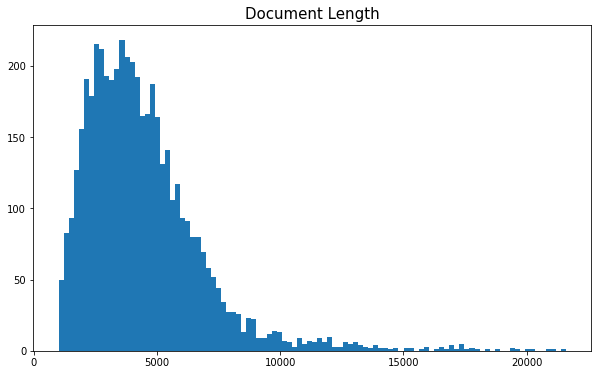

In [14]:
plt.figure(figsize=(10,6))
plt.title('Document Length', fontsize=15)
plt.hist(train_doc_len, bins=100)
plt.show()

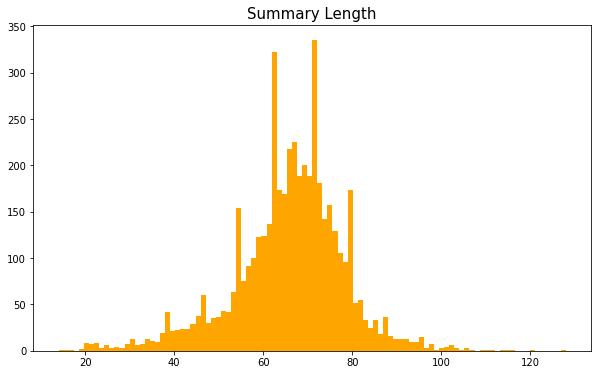

In [15]:
plt.figure(figsize=(10,6))
plt.title('Summary Length', fontsize=15)
plt.hist(train_summary_len, color='orange', bins=100)
plt.show()

## Preprocessor

In [16]:
preprocessor = Preprocessor()
datasets.cleanup_cache_files()
datasets = datasets.map(preprocessor.preprocess4train)

## Tokenization

In [17]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [18]:
tokenizer = AutoTokenizer.from_pretrained('t5-small')

/opt/conda/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [29]:
unk_tokens = []

In [30]:
for doc in tqdm(train_documents) :
    sen_list = sent_tokenize(doc)

    for sen in sen_list :
        word_list = word_tokenize(sen)

        for word in word_list :
            if tokenizer.unk_token_id == tokenizer.convert_tokens_to_ids(word) :
                unk_tokens.append(word)


100%|██████████| 158328/158328 [25:26<00:00, 103.73it/s]


In [33]:
unk_token_counter = collections.Counter()

In [34]:
unk_token_counter.update(unk_tokens)

In [35]:
len(unk_token_counter)

775515

In [59]:
unk_token_dict = sorted(unk_token_counter.items(), key=lambda x : x[1], reverse=True)

In [64]:
tok_list = [tok[0] for tok in unk_token_dict]
count_list = [tok[1] for tok in unk_token_dict]
idx_list = list(range(len(unk_token_dict)))

unk_token_dict = pd.DataFrame({'Token' : tok_list,
    'Count' : count_list, 
    'Index' : idx_list})

In [67]:
unk_token_dict.to_csv('../Tokenizer/unk_tokens.csv')

## Tokenizer Optimization

In [105]:
tokenizer = AutoTokenizer.from_pretrained('t5-small')

/opt/conda/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [106]:
def get_size(tokenizer) :
    count = 0 
    for tok in tokenizer.vocab :
        if 'extra_id' in tok :
            count += 1
    return count

In [107]:
get_size(tokenizer)

100

In [88]:
tokenizer.save_pretrained('../Tokenizer')

('../Tokenizer/tokenizer_config.json',
 '../Tokenizer/special_tokens_map.json',
 '../Tokenizer/tokenizer.json')

In [89]:
extra_token_df = pd.read_csv('../Tokenizer/extra_tokens.csv')
extra_token_list = list(extra_token_df['Token'][:100])

### special_tokens_map.json

In [90]:
with open('../Tokenizer/special_tokens_map.json') as json_file:
    special_tokens_map = json.load(json_file)

special_tokens_map['additional_special_tokens'] = extra_token_list

with open('../Tokenizer/special_tokens_map.json', 'w') as json_file:
    json.dump(special_tokens_map, json_file)

### tokenizer_config.json

In [91]:
with open('../Tokenizer/tokenizer_config.json') as json_file:
    tokenizer_config = json.load(json_file)

tokenizer_config['additional_special_tokens'] = extra_token_list

with open('../Tokenizer/tokenizer_config.json', 'w') as json_file:
    json.dump(tokenizer_config, json_file)

### tokenizer.json

In [92]:
with open('../Tokenizer/tokenizer.json') as json_file:
    tokenizer_data = json.load(json_file)

In [93]:
tokenizer_data.keys()

dict_keys(['version', 'truncation', 'padding', 'added_tokens', 'normalizer', 'pre_tokenizer', 'post_processor', 'decoder', 'model'])

In [94]:
len(tokenizer_data['model']['vocab'])

32100

In [95]:
# model vocab
for i in range(32000, len(tokenizer)) :
    tokenizer_data['model']['vocab'][i] = [extra_token_list[i-32000], 0.0]

In [99]:
for i in range(3, len(tokenizer_data['added_tokens'])) :
    tokenizer_data['added_tokens'][i]['content'] = extra_token_list[i-3]

In [100]:
with open('../Tokenizer/tokenizer.json', 'w') as json_file:
    json.dump(tokenizer_data, json_file)

## Optimize Result

In [101]:
tokenizer = AutoTokenizer.from_pretrained('../Tokenizer', extra_ids=0)

In [102]:
len(tokenizer)

32100

In [103]:
tokenizer.convert_tokens_to_ids('as')

32000